# Plot PeptoneBench Results


In [1]:
import json
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from peptonebench.config import DB_CS, DB_SAXS
from peptonebench.plotting import get_lowess_fit

pep_cs_df = pd.read_csv(
    DB_CS,
    index_col="label",
    converters={"gscores": lambda s: np.asarray(json.loads(s), dtype=float)},
)
pep_saxs_df = pd.read_csv(DB_SAXS, index_col="label")

In [2]:
# set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

g_name = {
    "alphafold": "AlphaFold2",
    "bioemu": "BioEmu",
    "boltz1x": "Boltz1x",
    "boltz2": "Boltz2",
    "esmflow": "ESMFlow",
    "esmfold": "ESMFold",
    "idp-o": "IDP-o",
    "idpfold": "IDPFold",
    "idpgan": "idpGAN",
    "idpsam": "idpSAM",
    "peptron_stable_pdb_20250809_236800": "PepTron-base",
    "peptron_stable_pdb_idrome_20250812_256000": "PepTron",
    "random_coil": "Random Coil",
}

In [ ]:
generators = [
    "alphafold",
    "esmfold",
    "idp-o",
    "idpgan",
    "idpfold",
    "idpsam",
    "boltz1x",
    "boltz2",
    "esmflow",
    "bioemu",
    "peptron_stable_pdb_20250809_236800",
    "peptron_stable_pdb_idrome_20250812_256000",
]
cs_tag = "UCBshift"
saxs_tag = "Pepsi"
failed_penalty = 0.1

info_cs = {}
info_saxs = {}
base_path = "../.."
for generator in tqdm(generators):
    filename = (
        f"{base_path}/PEP_ChemicalShifts/generated_ensembles-moderate-v2/{generator}/rew_info-{cs_tag}-filtered-new.csv"
    )
    if not os.path.exists(filename):
        !PeptoneBench -f {os.path.dirname(filename)}
    info_cs[generator] = pd.read_csv(filename, index_col="label")
    filename = f"{base_path}/PEP_saxs/generated_ensembles-unbalanced-v2/{generator}/rew_info-filtered-new.csv"
    if not os.path.exists(filename):
        !PeptoneBench -f {os.path.dirname(filename)} #--gen-filename out-LABEL/saxs_curves.csv
    info_saxs[generator] = pd.read_csv(filename, index_col="label")


100%|██████████| 12/12 [00:00<00:00, 343.52it/s]


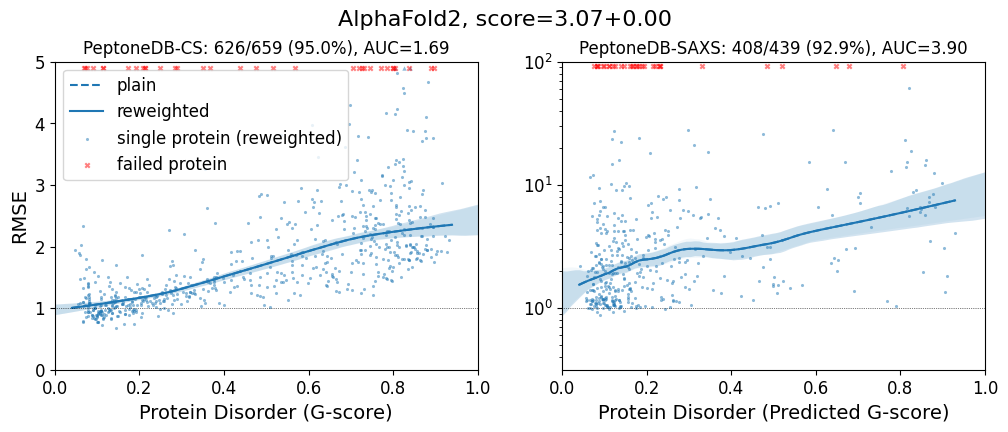

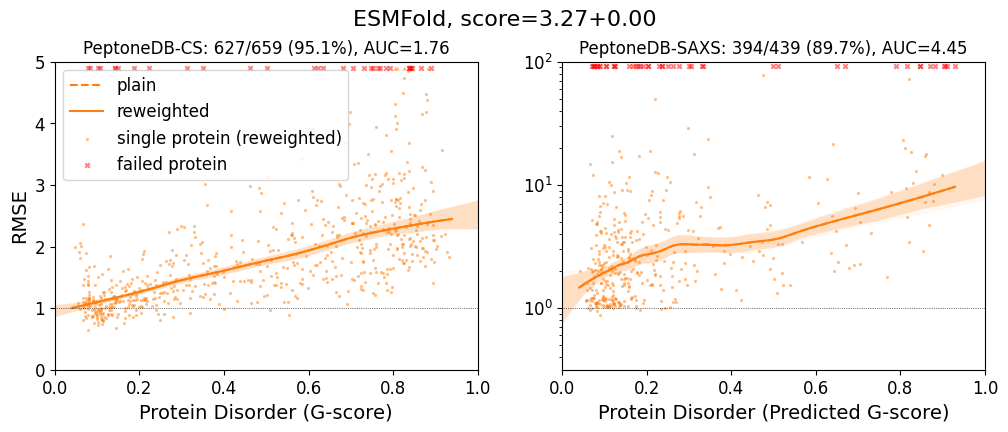

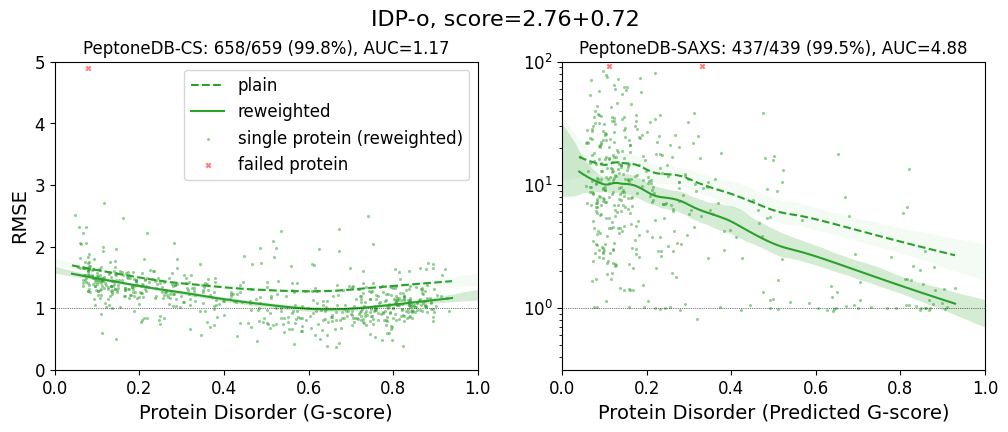

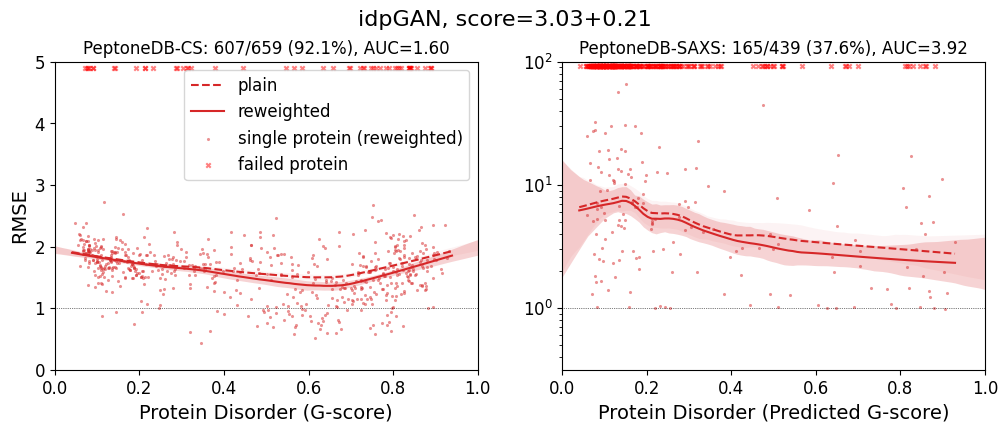

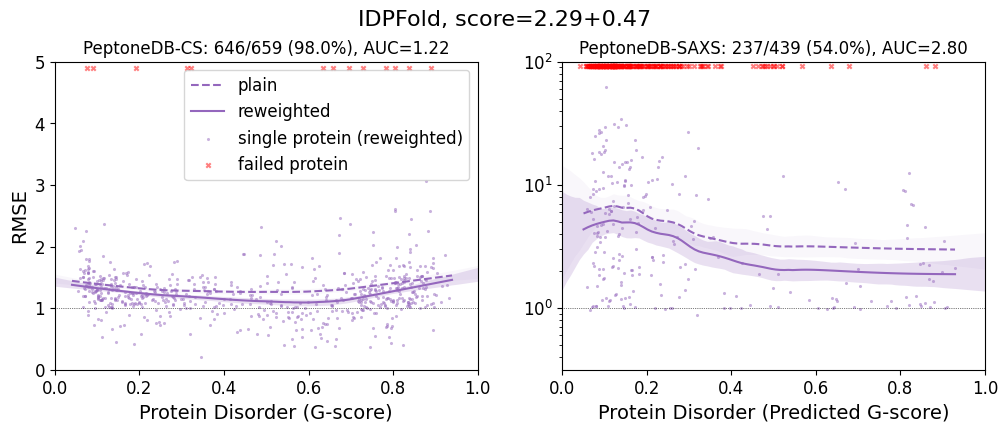

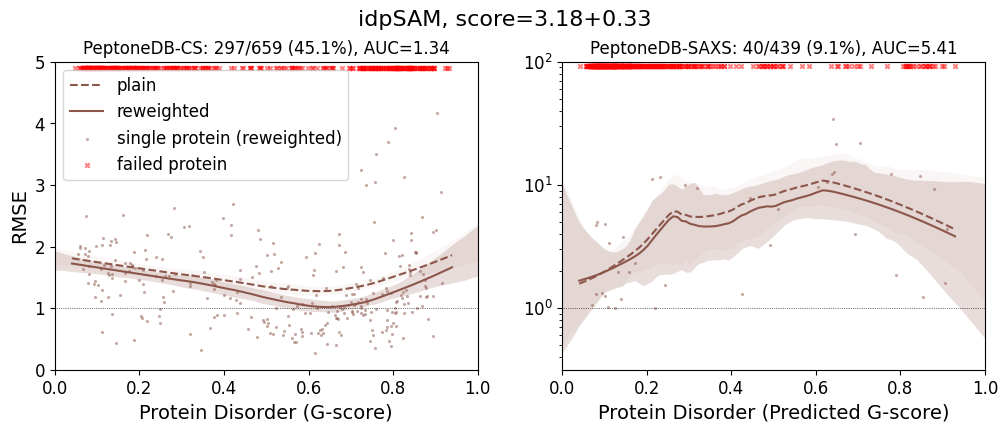

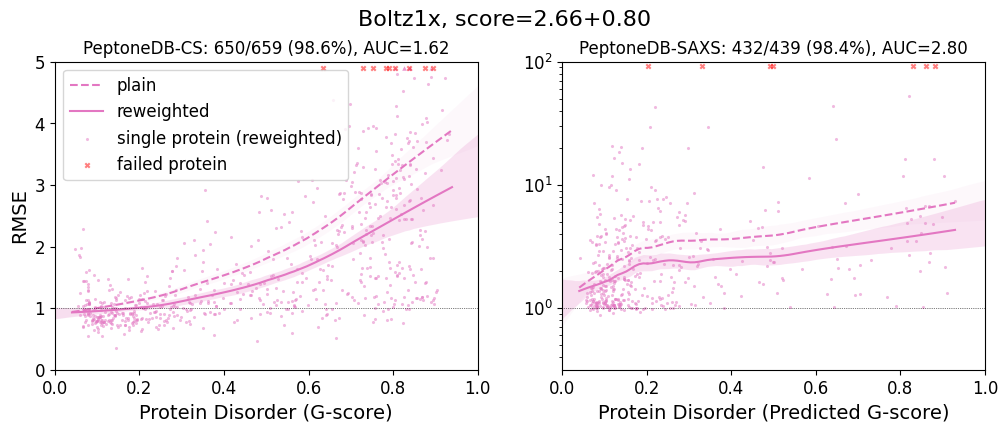

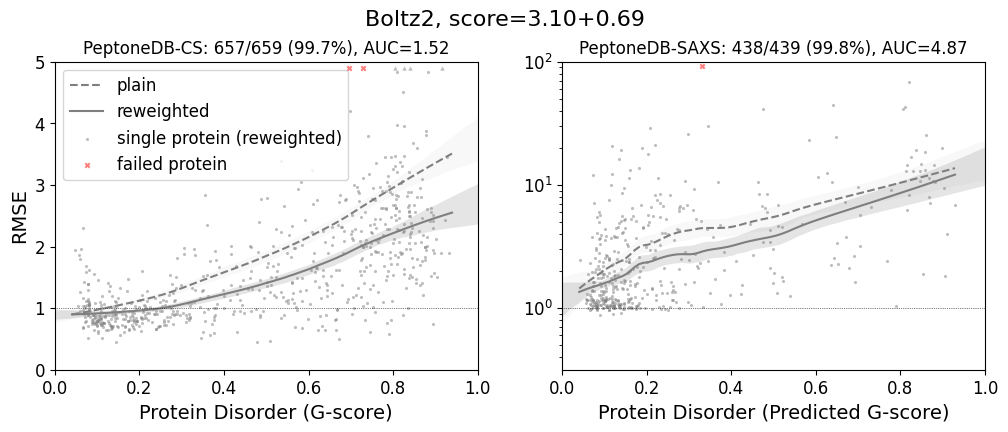

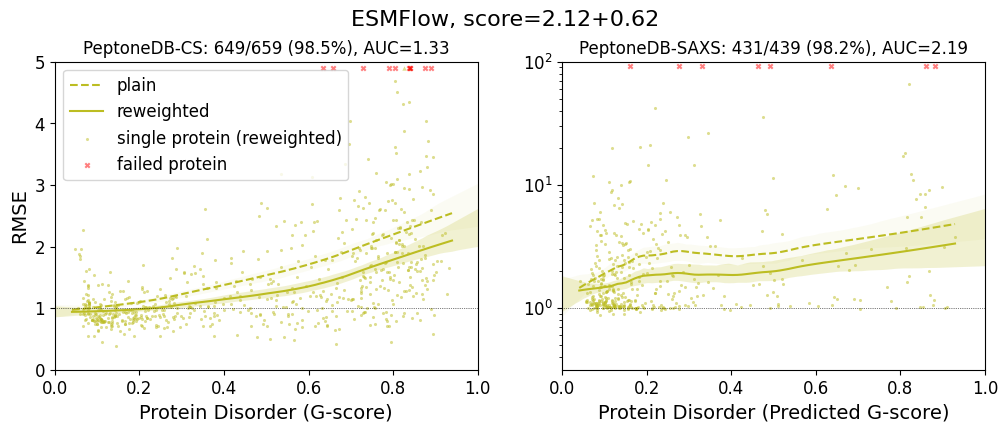

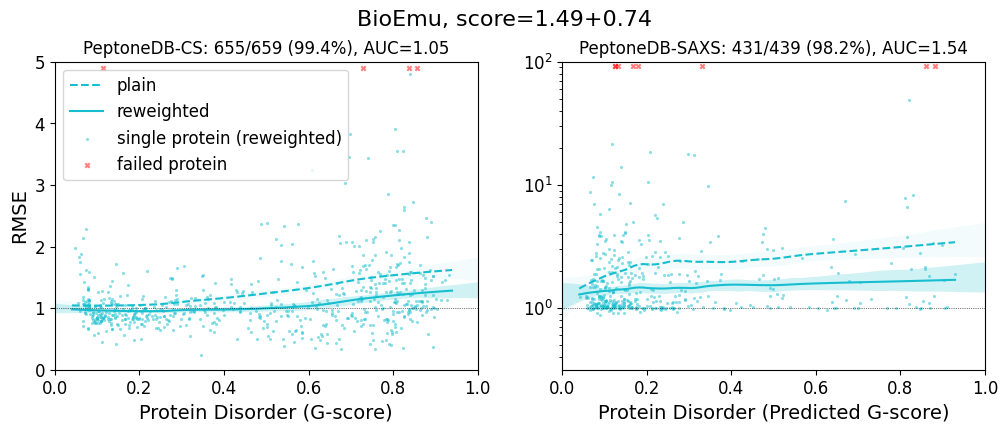

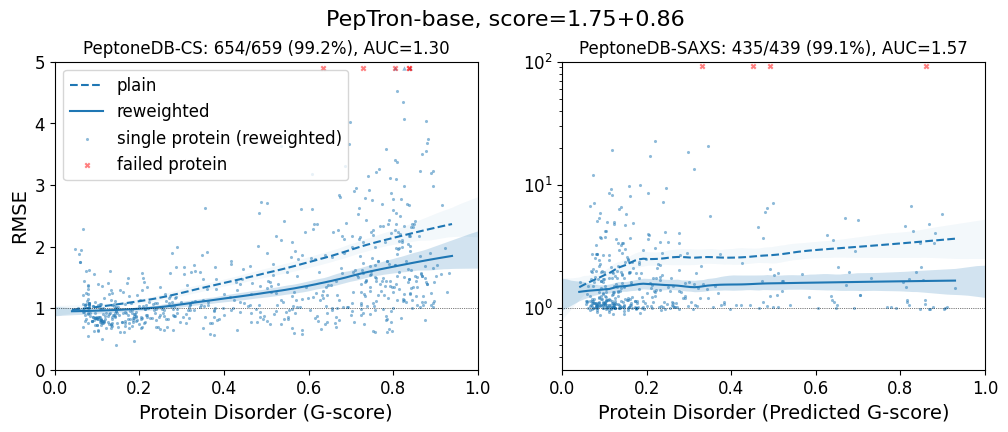

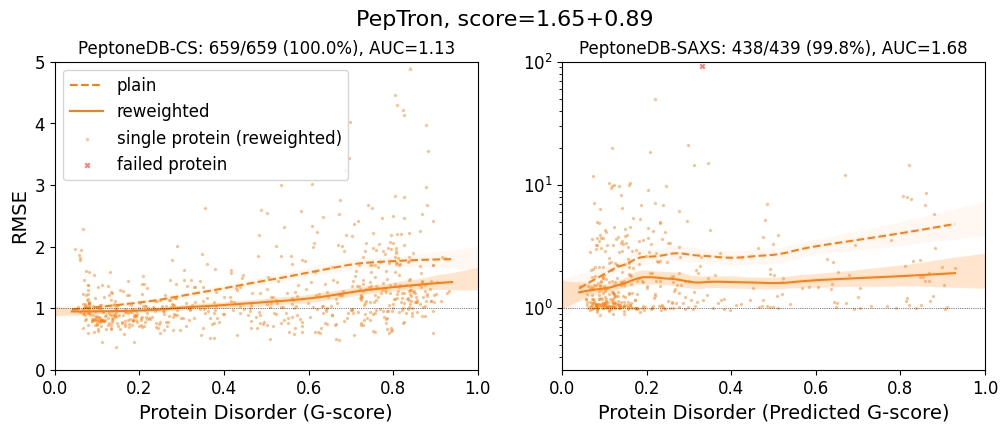

In [4]:
save_figures = False

lim_rmse_cs = 5.0  # 7.0
lim_rmse_saxs = 100.0
x_grid = np.linspace(0, 1, 100)
dx = x_grid[1] - x_grid[0]
for i, generator in enumerate(generators):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    x = pep_cs_df.loc[info_cs[generator].index, "mean_gscore"].to_numpy()
    range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
    info = info_cs[generator]
    y = info["RMSE"].to_numpy()
    yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
    plt.plot(x_grid[range_mask], yfit[range_mask], c=f"C{i}", ls="--", label="plain")
    plt.fill_between(x_grid, lower, upper, alpha=0.05, color=f"C{i}", lw=0)
    score = np.nanmean(yfit[range_mask]) + failed_penalty * (1 - sum(np.isfinite(y)) / len(pep_cs_df))
    y = info["rew_RMSE"].to_numpy()
    yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
    plt.title(
        f"PeptoneDB-CS: {sum(np.isfinite(y))}/{len(pep_cs_df)} ({sum(np.isfinite(y)) / len(pep_cs_df):.1%})"
        f", AUC={yfit[range_mask].mean():.2f}",
    )
    rew_score = np.nanmean(yfit[range_mask]) + failed_penalty * (1 - sum(np.isfinite(y)) / len(pep_cs_df))
    plt.plot(x_grid[range_mask], yfit[range_mask], c=f"C{i}", label="reweighted")
    plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
    y_edge = 0.1
    outside_y = y >= lim_rmse_cs - y_edge
    plt.scatter(x[~outside_y], y[~outside_y], s=5, alpha=0.5, lw=0, c=f"C{i}", label="single protein (reweighted)")
    if sum(outside_y) > 0:
        plt.scatter(x[outside_y], [lim_rmse_cs - y_edge] * sum(outside_y), s=10, alpha=0.5, lw=0, c=f"C{i}", marker="^")
    missing_labels = list(set(pep_cs_df.index) - set(info.index[np.isfinite(info["rew_RMSE"])]))
    if len(missing_labels) > 0:
        x = pep_cs_df.loc[missing_labels, "mean_gscore"].to_numpy()
        y = np.full(len(x), lim_rmse_cs - y_edge)
    else:  # for the legend
        x, y = [], []
    plt.scatter(x, y, s=10, alpha=0.5, c="r", marker="x", label="failed protein")
    plt.xlim(0, 1)
    plt.ylim(0, lim_rmse_cs)
    plt.xlabel("Protein Disorder (G-score)")
    plt.ylabel("RMSE")
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    info = info_saxs[generator]
    x = pep_saxs_df.loc[info.index, "mean_gscore_adopt2"].to_numpy()
    range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
    y = np.log(info["RMSE"].to_numpy())
    yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
    y, yfit, lower, upper = map(np.exp, (y, yfit, lower, upper))
    plt.plot(x_grid[range_mask], yfit[range_mask], c=f"C{i}", ls="--")
    plt.fill_between(x_grid, lower, upper, alpha=0.05, color=f"C{i}", lw=0)
    score += np.log(np.nanmean(yfit[range_mask])) + failed_penalty * (1 - sum(np.isfinite(y)) / len(pep_saxs_df))
    y = np.log(info["rew_RMSE"].to_numpy())
    yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
    y, yfit, lower, upper = map(np.exp, (y, yfit, lower, upper))
    plt.title(
        f"PeptoneDB-SAXS: {sum(np.isfinite(y))}/{len(pep_saxs_df)} ({sum(np.isfinite(y)) / len(pep_saxs_df):.1%})"
        f", AUC={yfit[range_mask].mean():.2f}",
    )
    rew_score += np.log(np.nanmean(yfit[range_mask])) + failed_penalty * (1 - sum(np.isfinite(y)) / len(pep_saxs_df))
    plt.plot(x_grid[range_mask], yfit[range_mask], c=f"C{i}")
    plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
    y_edge = lim_rmse_saxs * (1 - 0.925)
    outside_y = y >= lim_rmse_saxs - y_edge
    plt.scatter(x[~outside_y], y[~outside_y], s=5, alpha=0.5, lw=0, c=f"C{i}")
    if sum(outside_y) > 0:
        plt.scatter(
            x[outside_y],
            [lim_rmse_saxs - y_edge] * sum(outside_y),
            s=10,
            alpha=0.5,
            lw=0,
            c=f"C{i}",
            marker="^",
        )
    missing_labels = list(set(pep_saxs_df.index) - set(info.index[np.isfinite(info["rew_RMSE"])]))
    if len(missing_labels) > 0:
        x = pep_saxs_df.loc[missing_labels, "mean_gscore_adopt2"].to_numpy()
        y = np.full(len(x), lim_rmse_saxs - y_edge)
        plt.scatter(x, y, s=10, alpha=0.5, c="r", marker="x")
    plt.xlim(0, 1)
    plt.ylim(10 ** (np.log10(lim_rmse_saxs) / (1 - lim_rmse_cs)), lim_rmse_saxs)
    plt.yscale("log")
    plt.xlabel("Protein Disorder (Predicted G-score)")
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.suptitle(f"{g_name[generator]}, score={rew_score:.2f}+{score - rew_score:.2f}", y=1.01)
    if save_figures:
        plt.savefig(f"bench_{generator}.png", dpi=300, bbox_inches="tight")
    plt.show()

 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]

100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


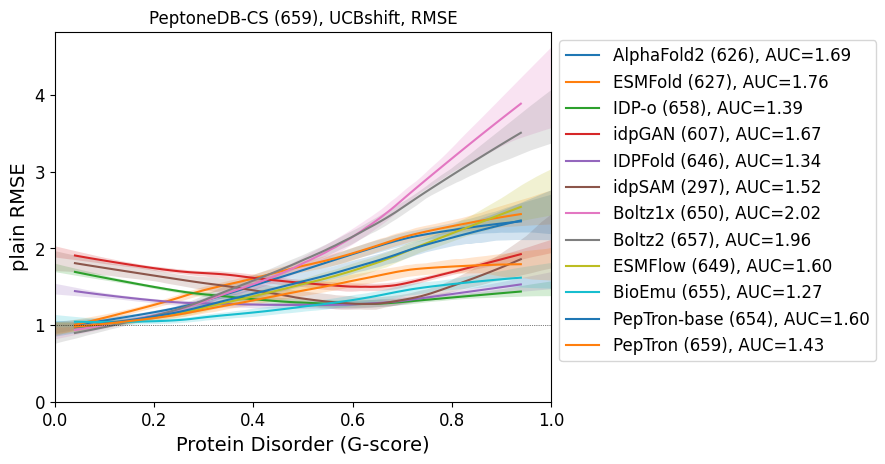

100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


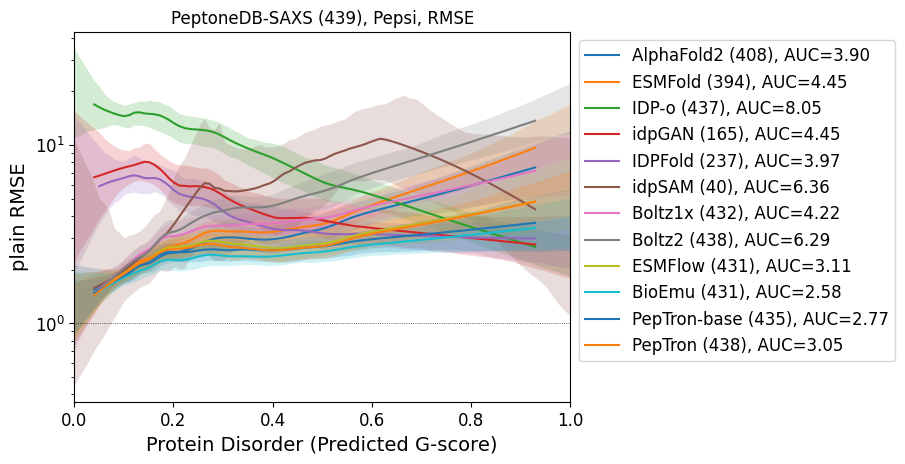

100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


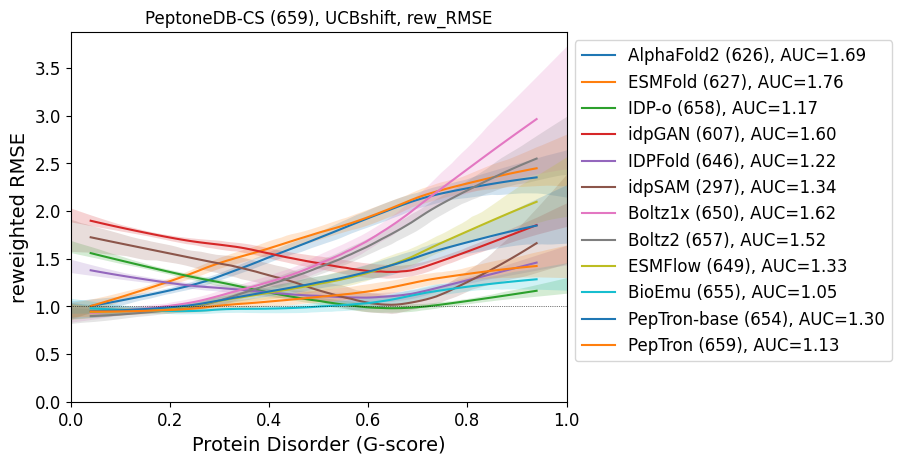

100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


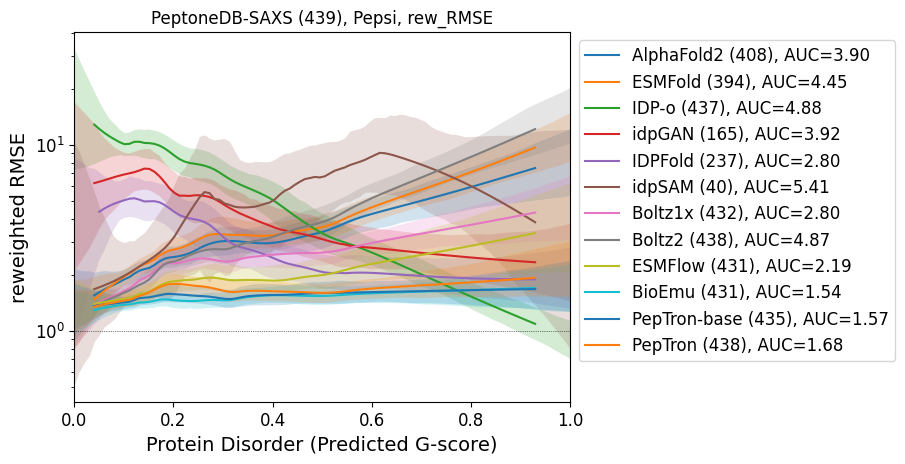

In [5]:
score = {}

x_grid = np.linspace(0, 1, 100)
dx = x_grid[1] - x_grid[0]
for chosen_rmse in ["RMSE", "rew_RMSE"]:
    score[chosen_rmse] = {}
    plt.title(f"PeptoneDB-CS ({len(pep_cs_df)}), {cs_tag}, {chosen_rmse}")
    for i, generator in enumerate(tqdm(generators)):
        info = info_cs[generator]
        x = pep_cs_df.loc[info.index, "mean_gscore"].to_numpy()
        y = info[chosen_rmse].to_numpy()
        range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
        yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
        plt.plot(
            x_grid[range_mask],
            yfit[range_mask],
            c=f"C{i}",
            ls="--" if generator == "random_coil" else "-",
            label=f"{g_name[generator]} ({sum(np.isfinite(y))}), AUC={yfit[range_mask].mean():.2f}",
        )
        plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
        score[chosen_rmse][generator] = np.nanmean(yfit[range_mask]) + failed_penalty * (
            1 - sum(np.isfinite(y)) / len(pep_cs_df)
        )
    plt.xlim(x_grid.min(), x_grid.max())
    plt.ylim(0, None)
    plt.xlabel("Protein Disorder (G-score)")
    plt.ylabel("plain RMSE" if chosen_rmse == "RMSE" else "reweighted RMSE")
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()

    plt.title(f"PeptoneDB-SAXS ({len(pep_saxs_df)}), {saxs_tag}, {chosen_rmse}")
    for i, generator in enumerate(tqdm(generators)):
        info = info_saxs[generator]
        x = pep_saxs_df.loc[info.index, "mean_gscore_adopt2"].to_numpy()
        y = np.log(info[chosen_rmse].to_numpy())
        range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
        yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
        y, yfit, lower, upper = map(np.exp, (y, yfit, lower, upper))
        plt.plot(
            x_grid[range_mask],
            yfit[range_mask],
            c=f"C{i}",
            label=f"{g_name[generator]} ({sum(np.isfinite(y))}), AUC={yfit[range_mask].mean():.2f}",
        )
        plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
        score[chosen_rmse][generator] += np.log(np.nanmean(yfit[range_mask])) + failed_penalty * (
            1 - sum(np.isfinite(y)) / len(pep_saxs_df)
        )
    plt.xlim(0, 1)
    # plt.ylim(10 ** (np.log10(lim_rmse_saxs) / (1 - lim_rmse_cs)), lim_rmse_saxs)
    plt.yscale("log")
    plt.xlabel("Protein Disorder (Predicted G-score)")
    plt.ylabel("plain RMSE" if chosen_rmse == "RMSE" else "reweighted RMSE")
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()

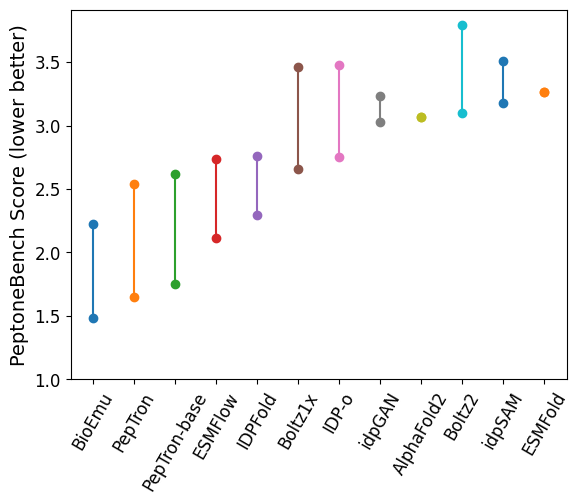

PeptoneBench Scores
Generator:  Plain,  Reweighted
  BioEmu      : 2.22, 1.49
  PepTron     : 2.54, 1.65
  PepTron-base: 2.62, 1.75
  ESMFlow     : 2.74, 2.12
  IDPFold     : 2.76, 2.29
  Boltz1x     : 3.46, 2.66
  IDP-o       : 3.48, 2.76
  idpGAN      : 3.24, 3.03
  AlphaFold2  : 3.07, 3.07
  Boltz2      : 3.80, 3.10
  idpSAM      : 3.51, 3.18
  ESMFold     : 3.27, 3.27


In [6]:
save_figures = False

for i, generator in enumerate(sorted(score["rew_RMSE"], key=lambda g: score["rew_RMSE"][g])):
    plt.plot(
        [i, i],
        [score["rew_RMSE"][generator], score["RMSE"][generator]],
        "-o",
        label=g_name[generator],
    )
plt.ylabel("PeptoneBench Score (lower better)")
plt.xticks(
    range(len(score["rew_RMSE"])),
    [g_name[g] for g in sorted(score["rew_RMSE"], key=lambda g: score["rew_RMSE"][g])],
    rotation=60,
)
plt.ylim(1, None)
if save_figures:
    plt.savefig("PeptoneBenchScore.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("PeptoneBench Scores")
print("Generator:  Plain,  Reweighted")
for generator in sorted(generators, key=lambda g: score["rew_RMSE"][g]):
    print(f"  {g_name[generator]:<12}: {score['RMSE'][generator]:.2f}, {score['rew_RMSE'][generator]:.2f}")

 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


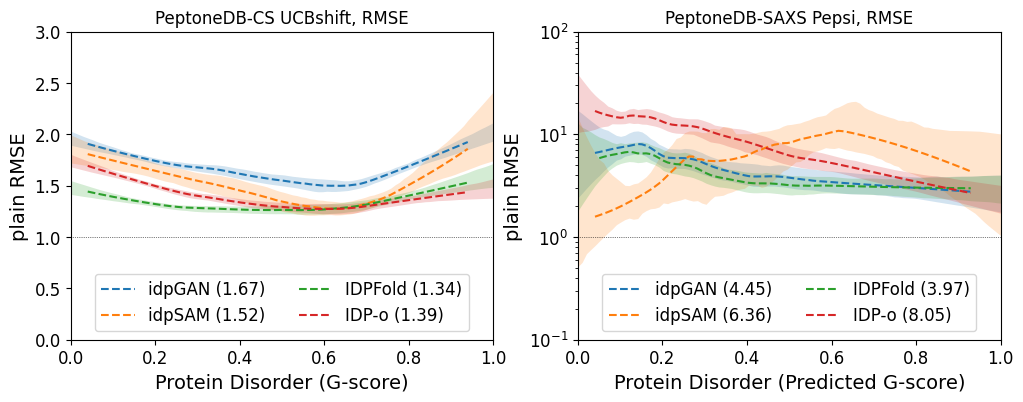

100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


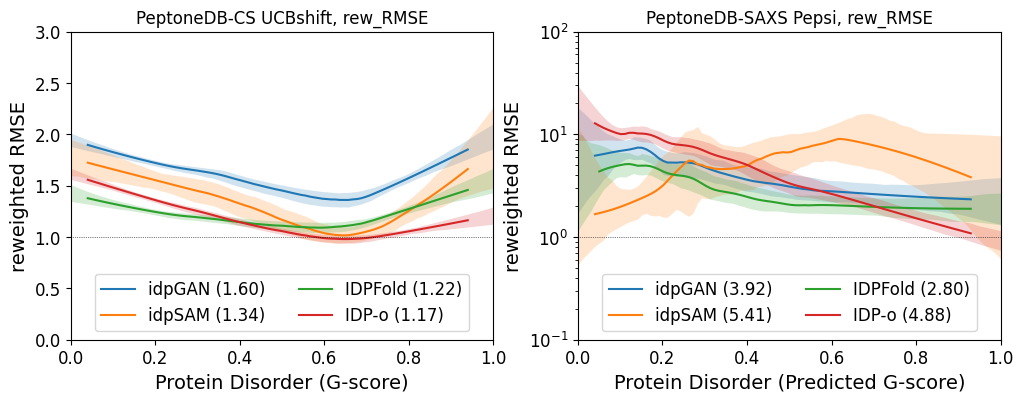

{'RMSE': {'idpgan': np.float64(3.1658055088198567),
  'idpsam': np.float64(3.3652107044513926),
  'idpfold': np.float64(2.7140959161822793),
  'idp-o': np.float64(3.4792808593579587)},
 'rew_RMSE': {'idpgan': np.float64(2.960798972008627),
  'idpsam': np.float64(3.0327554187693924),
  'idpfold': np.float64(2.2465635196401506),
  'idp-o': np.float64(2.7549896816731896)}}

In [ ]:
# my_generators = ["alphafold", "boltz2", "bioemu", "peptron_stable_pdb_idrome_20250812_256000"]
# my_generators = ["esmfold", "esmflow", "idp-o", "peptron_stable_pdb_idrome_20250812_256000"]
my_generators = ["idpgan", "idpsam", "idpfold", "idp-o"]

save_figures = False
lim_rmse_cs = 3.0
lim_rmse_saxs = 100.0
score = {}

x_grid = np.linspace(0, 1, 100)
dx = x_grid[1] - x_grid[0]
for chosen_rmse, ls in zip(["RMSE", "rew_RMSE"], ["--", "-"]):
    ylabel = "plain RMSE" if chosen_rmse == "RMSE" else "reweighted RMSE"
    score[chosen_rmse] = {}
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"PeptoneDB-CS {cs_tag}, {chosen_rmse}")
    for i, generator in enumerate(tqdm(my_generators)):
        info = info_cs[generator]
        x = pep_cs_df.loc[info.index, "mean_gscore"].to_numpy()
        y = info[chosen_rmse].to_numpy()
        range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
        yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
        plt.plot(
            x_grid[range_mask],
            yfit[range_mask],
            c=f"C{i}",
            ls=ls,
            # label=f"{g_name[generator]} ({sum(np.isfinite(y))}) -> {np.nanmean(yfit[range_mask]):.2f}",
            label=f"{g_name[generator]} ({np.nanmean(yfit[range_mask]):.2f})",
        )
        plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
        score[chosen_rmse][generator] = np.nanmean(yfit[range_mask])
    plt.xlim(x_grid.min(), x_grid.max())
    plt.ylim(0, lim_rmse_cs)
    plt.xlabel("Protein Disorder (G-score)")
    plt.ylabel(ylabel)
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.legend(ncol=2, loc="lower center")

    plt.subplot(1, 2, 2)
    plt.title(f"PeptoneDB-SAXS {saxs_tag}, {chosen_rmse}")
    for i, generator in enumerate(tqdm(my_generators)):
        info = info_saxs[generator]
        x = pep_saxs_df.loc[info.index, "mean_gscore_adopt2"].to_numpy()
        y = np.log(info[chosen_rmse].to_numpy())
        range_mask = (x.min() - dx < x_grid) & (x_grid < x.max() + dx)
        yfit, lower, upper = get_lowess_fit(x, y, xvals=x_grid)
        y, yfit, lower, upper = map(np.exp, (y, yfit, lower, upper))
        plt.plot(
            x_grid[range_mask],
            yfit[range_mask],
            c=f"C{i}",
            ls=ls,
            label=f"{g_name[generator]} ({np.nanmean(yfit[range_mask]):.2f})",
        )
        plt.fill_between(x_grid, lower, upper, alpha=0.2, color=f"C{i}", lw=0)
        score[chosen_rmse][generator] += np.log(np.nanmean(yfit[range_mask]))
    plt.xlim(0, 1)
    plt.ylim(10 ** (np.log10(lim_rmse_saxs) / (1 - lim_rmse_cs)), lim_rmse_saxs)
    plt.yscale("log")
    plt.xlabel("Protein Disorder (Predicted G-score)")
    plt.ylabel(ylabel)
    plt.axhline(1, color="k", ls=":", lw=0.5)
    plt.legend(ncol=2, loc="lower center")
    if save_figures:
        plt.savefig(f"idp_models-{chosen_rmse}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

score